# 6. Tutorial: Create iML1515 RBA model

In accordance with the workflows delineated in the preceding tutorials, with minimal effort, we generated enzyme constraint GECKO models from a well-annotated genome-scale metabolic model (GEM), and subsequently adjusted model parameters. The f2xba framework supported the model generation, optimization, and results analysis. The extension of a genome-scale model, utilized for FBA analysis, to a GECKO model necessitated the division of enzyme-catalyzed reactions into forward and reverse directions and per isoenzyme. It also entailed the introduction of protein concentration variables, the addition of coupling constraints to link reaction fluxes to protein requirements, and the replacement of constraints on nutrient uptake fluxes with a total protein constraint. The fixed biomass reaction was retained in the GECKO model and served as a proxy for the specific growth rate. The majority of the model parameters were retrieved automatically from online resources.

In this tutorial, we will generate a resource balance constraint (RBA) (Goelzer et al., 2011) model of iML1515, the latest genome-scale metabolic model of *E. coli*. The f2xba package creates RBA models based on the formalism used in RBApy (Bulović et al., 2019), with some improvements. While RBApy exports models in a proprietary format, RBA models created with f2xba are fully annotated and formatted in standardized SBML language, allowing processing by SBML-compliant tools. Workflows for RBA model creation, optimization, and results analysis are consistent with the workflows for enzyme constraint GECKO models introduced in the previous tutorials. 

We will reuse the configuration data of our final GECKO model, including the auto-fitted turnover numbers. RBA necessitates a substantial augmentation of the metabolic network, incorporating organism-specific knowledge. Key components of RBA models are designated as "process machines" for macromolecule processing, including DNA, RNA, and protein synthesis, protein folding, and targeting. Furthermore, RBA employs compartment-specific capacity constraints for total protein and RNA, superseding the total protein constraint in GECKO models. The fixed biomass reaction employed in FBA and GECKO modeling is substituted by enzyme requirements and concentration targets. Michaelis-Menten derived rate laws are used for nutrient uptake reactions, and media conditions must be defined as specific nutrient concentrations rather than placing constraints on uptake fluxes. 

The optimization problems used for FBA and GECKO are replaced by feasibility problems, using a bisection algorithm to test for the maximal growth rate. At each growth rate, variable bounds and matrix coefficients must be recalculated and updated. RBA models coded in SBML utilize SBML features that are not accessible by cobrapy, such as initial assignments. Although cobrapy will be employed for RBA model loading and optimization, support by f2xba features is necessary. For larger and more complex models, such as genome-scale RBA models, the optimization interface based on gurobipy can provide substantial performance improvements over cobrapy.


## RBA implementation details

A comparison of the RBA and GECKO models reveals notable distinctions in their implementation. In the RBA model, reactions are divided according to isoenzyme, and no splitting in forward and reverse directions is required. Reactions are coupled at the enzyme level, while in the GECKO model, they are coupled at the protein level. The RBA model contains enzyme concentration variables, while the GECKO model contains protein concentration variables. A one-to-one relationship exists between reactions and modeled enzymes, with enzyme identifiers being derived from reaction identifiers. Enzymes are composed of proteins, which need to be produced by process machines. Enzymes may also require cofactors, which need to be provided by the metabolic network. The expression of protein and RNA masses is carried out in units of average amino acids, while the capacity constraints present in different compartments are expressed in units of mmol amino acids per gram cell dry weight (mmolAA/gDW).

Enzyme efficiency constraints for the forward $C\_EF_i$ and reverse $C\_ER_i$ directions couple reaction fluxes $R_i$ [mmol/gDWh] with enzyme concentrations $V\_EC_i$ [µmol/gDW] using apparent catalytic constants $kcat\_app_i$ [$h^{-1}$].

\begin{equation}
C\_EF_i: R_i - kcat\_app_i \cdot V\_EC_i \cdot 0.001 \leq 0 
C\_ER_i: - R_i - kcat\_app_i \cdot V\_EC_i \cdot 0.001  \leq 0
\end{equation}

The apparent catalytic constants are determined from the turnover numbers $kcat_i$ [$s^{-1}$], the number of active sites $n\_AS_i$, and the average enzyme saturation $avg\_enz\_sat$, which is used for all reactions. 

\begin{equation}
kcat\_app_i = kcat_i \cdot n\_AS_i  \cdot avg\_enz\_sat \cdot 3600$
\end{equation}

Macromolecular production reactions are incorporated to synthesize explicitly modeled proteins (e.g., R_PROD_b2907), balance dummy proteins (e.g., R_PROD_dummy_protein_im), and total DNA (R_PROD_dna), total mRNA (R_PROD_mrna), individual tRNAs (e.g., R_PROD_trnaala) and individual rRNAs (e.g., R_PROD_rRNA_16S), using metabolites produced in the metabolic reaction network. Process machine capacity constraints (e.g., C_PMC_pm_translation) couple these macromolecular production reactions to process machine concentrations (e.g., V_PMC_pm_translation) in the same way as metabolic reactions are coupled to enzyme requirements. Macromolecular degradation reactions are added in a similar way (e.g., R_DEGR_mrna).

It is important to note that macromolecules undergo dilution due to cellular growth. Mass balance constraints for macromolecules (e.g., MM_b2907) ensure that macromolecule production, degradation, and dilution are balanced. The dilution of modeled proteins and ribosomal RNAs is governed by enzyme concentration (e.g., V_EC_FBA_iso1) and process machine concentration (e.g., V_PCM_pm_translation) variables. The dilution of other macromolecules due to growth is managed by specific target concentration variables (e.g., V_TMMC_mrna). The variable 'V_TSMC' [µmol/gDW] controls the growth dilution of selected metabolites, mainly derived from the biomass pseudo reaction of the foundational GEM. Compartmental capacity limits are controlled by the variable 'V_TCD' [mmolAA/gDW]. Density constraints (e.g., C_D_im) serve to regulate the concentrations of enzymes, processes, machines, and macromolecular targets, ensuring that these concentrations do not exceed the capacities of the respective compartments.

Peter Schubert, Heinrich-Heine University Duesseldorf, Institute for Computational Cell Biology (Prof. Dr. M. Lercher), January, 2025



## Step 1: Initial setup

In order to perform RBA modeling, it is necessary to import the following classes: `RbaModel`, `RbaOptimization`, and `RbaResults`.

In [1]:
import os
import re
import time
import pandas as pd
import cobra

from f2xba import XbaModel, RbaModel
from f2xba import RbaOptimization, RbaResults
from f2xba.utils.mapping_utils import load_parameter_file, write_parameter_file

fba_model = 'iML1515'
gecko_model = 'iML1515_predicted_fit_GECKO'
target_model = 'iML1515_RBA'
reference_cond = 'Glucose'

# Create media conditions
media_grs = {'Acetate': ['ac', 0.29], 'Glycerol': ['glyc', 0.47], 'Fructose': ['fru', 0.54], 
             'L-Malate': ['mal__L', 0.55], 'Glucose': ['glc__D', 0.66], 'Glucose 6-Phosphate': ['g6p', 0.78]}
base_medium = ['ca2', 'cbl1', 'cl', 'co2', 'cobalt2', 'cu2', 'fe2', 'fe3', 'h2o', 'h', 'k', 'mg2', 
               'mn2', 'mobd', 'na1', 'nh4', 'ni2', 'o2', 'pi', 'sel', 'slnt', 'so4', 'tungs', 'zn2']
conditions = {}
exp_grs = {}
for cond, (carbon_sid, exp_gr )in media_grs.items():
    conditions[cond] = {f'EX_{sidx}_e': 1000.0 for sidx in base_medium}
    conditions[cond][f'EX_{carbon_sid}_e'] = 1000.0
    exp_grs[cond] = exp_gr
print(f'{len(conditions)} minimal media conditions created for simulation')

# Load proteomics
fname = os.path.join('data', 'Ecoli_Schmidt_proteomics.xlsx')
with pd.ExcelFile(fname) as xlsx:
    df_mpmf = pd.read_excel(xlsx, sheet_name='proteomics', index_col=0)
    print(f'{len(df_mpmf)} records of proteomics loaded from {fname}')
min_confidence_level = 43.0
df_mpmf = df_mpmf[df_mpmf['confidence'] > min_confidence_level]
print(f'{len(df_mpmf)} records with confidence level above {min_confidence_level}')

6 minimal media conditions created for simulation
2347 records of proteomics loaded from data/Ecoli_Schmidt_proteomics.xlsx
2232 records with confidence level above 43.0


## Step 2: Create XBA and RBA configuration files

RBA models are considerably more intricate than GECKO models and necessitate a significant investment in model parametrization. Fortunately, numerous parameters have already been delineated in the GECKO model, and this configuration data can be reused. The data that will be added is relatively structured and can be easily reused with minimal modifications. The RBA model that will be developed in this tutorial is relatively sophisticated. In practice, it might be more prudent to begin with a very simple RBA model, such as one that has only a single process machinery for protein synthesis. This preliminary model can then be extended iteratively to gain more control over parametrization and to identify any modeling problems. As with the GECKO model, the generation of the RBA model is based on configuration files. In this case, we required XBA and RBA configuration files.

### 2.1 create XBA configuration file

The XBA configuration file, which was utilized to generate the baseline GECKO model, is expanded. Within the `general` table, the GenBank accession identifier for the ‘*Escherichia coli* str. K-12 substr. MG1655’ chromosome is assigned to the parameter `chromosome2accids`. Additionally, the inclusion of cofactors in enzyme compositions is requested by setting the `cofactor_flag` to ‘True’.  The cofactor requirements are extracted from UniProt and mapped to metabolites in the model. 

The `modify_addrs` table will not be reused; rather, a new table is created in which three transport reactions are blocked by setting the upper flux bound to zero. It is not necessary to explicitly block the reaction ‘GLCDpp’ because RBA will not use this reaction unless the cofactor PQQ is supplied, which is also added to the model species.

The protein translation machinery that is to be introduced requires charged tRNAs for translation initiation and elongation; with the exception of glutamyl-tRNA, iML1515 natively cannot synthesize charged tRNAs. Consequently, the tRNA charging reactions must be incorporated into the reaction network (`add_reactions` table), along with model species representing charged and uncharged tRNAs (`add_species`) and the gene products necessary to catalyze tRNA charging reactions (`add_gps`). The iJO1366 model (Orth et al., 2011) is the precursor to the iML1515 model. The tRNA charging reactions were defined in the iJO1366 model and were subsequently eliminated during the construction of the iML1515 model. The relevant reaction data acquired from the iJO1366 model has been compiled in the `data` structure. This data is utilized in the automatic generation of most configuration data.

#### Configuration data for other organisms:   

The RBA model creation process necessitates the utilization of information from the genome to ascertain the composition of various types of RNA and DNA. Additionally, genome information can be employed to determine protein composition in instances where UniProt protein data records for the organism are not available. It is imperative to assign either NCBI GenBank or RefSeq accession numbers to the parameter `chromosome2accids`. It should be noted that the corresponding genome records contain the gene locus identifiers employed in the model. In instances where the genome is distributed across multiple chromosomes and/or plastids, it is essential that all pertinent segments are provided. For instance, the values designated for the parameter `chromosome2accids` in the configuration file for *Saccharomyces cerevisiae* may begin with: 'Chr_I=BK006935.2, Chr_II=BK006936.2, Chr_III=BK006937.2, …'.

In [2]:
# add tRNA charging reactions, (R_GLUTRS, Glutamyl-tRNA synthetase, already exists in iML1515)
data = [
    ['R_ALATRS', 'Alanyl-tRNA synthetase', 'G_b2697', 'ala__L_c', 'trnaala_c', 'alatrna_c'],
    ['R_ARGTRS', 'Arginyl-tRNA synthetase', 'G_b1876', 'arg__L_c', 'trnaarg_c', 'argtrna_c'],
    ['R_ASNTRS', 'Asparaginyl-tRNA synthetase', 'G_b0930', 'asn__L_c', 'trnaasn_c', 'asntrna_c'],
    ['R_ASPTRS', 'Aspartyl-tRNA synthetase', 'G_b1866', 'asp__L_c', 'trnaasp_c', 'asptrna_c'],
    ['R_CYSTRS', 'Cysteinyl-tRNA synthetase', 'G_b0526', 'cys__L_c', 'trnacys_c', 'cystrna_c'],
    ['R_GLNTRS', 'Glutaminyl-tRNA synthetase', 'G_b0680', 'gln__L_c', 'trnagln_c', 'glntrna_c'],
    ['R_GLYTRS', 'Glycyl-tRNA synthetase', '(G_b3559 and G_b3560)', 'gly_c', 'trnagly_c', 'glytrna_c'],
    ['R_HISTRS', 'Histidyl-tRNA synthetase', 'G_b2514', 'his__L_c', 'trnahis_c', 'histrna_c'],
    ['R_ILETRS', 'Isoleucyl-tRNA synthetase', 'G_b0026', 'ile__L_c', 'trnaile_c', 'iletrna_c'],
    ['R_LEUTRS', 'Leucyl-tRNA synthetase', 'G_b0642', 'leu__L_c', 'trnaleu_c', 'leutrna_c'],
    ['R_LYSTRS', 'Lysyl-tRNA synthetase', '(G_b4129 or G_b2890)', 'lys__L_c', 'trnalys_c', 'lystrna_c'],
    ['R_METTRS', 'Methionyl-tRNA synthetase', 'G_b2114', 'met__L_c', 'trnamet_c', 'mettrna_c'],
    ['R_PHETRS', 'Phenylalanyl-tRNA synthetase', '(G_b1713 and G_b1714)', 'phe__L_c', 'trnaphe_c', 'phetrna_c'],
    ['R_PROTRS', 'Prolyl-tRNA synthetase', 'G_b0194', 'pro__L_c', 'trnapro_c', 'protrna_c'],
    ['R_SERTRS', 'Seryl-tRNA synthetase', 'G_b0893', 'ser__L_c', 'trnaser_c', 'sertrna_c'],
    ['R_SERTRS2', 'Seryl-tRNA synthetase (selenocystein)', 'G_b0893', 'ser__L_c', 'trnasecys_c', 'sertrna_sec_c'],
    ['R_THRTRS', 'Threonyl-tRNA synthetase', 'G_b1719', 'thr__L_c', 'trnathr_c', 'thrtrna_c'],
    ['R_TRPTRS', 'Tryptophanyl-tRNA synthetase', 'G_b3384', 'trp__L_c', 'trnatrp_c', 'trptrna_c'],
    ['R_TYRTRS', 'Tyrosyl-tRNA synthetase', 'G_b1637', 'tyr__L_c', 'trnatyr_c', 'tyrtrna_c'],
    ['R_VALTRS', 'Valyl-tRNA synthetase', 'G_b4258', 'val__L_c', 'trnaval_c', 'valtrna_c'],
]

# add tRNA charging reactions
add_reactions_cols = ['id', 'name', 'fbcGeneProdAssoc', 'reactionString', 'fbcLb', 'fbcUb']
add_reactions = [
    ['R_FMETTRS', 'Methionyl-tRNA formyltransferase', 'assoc=G_b3288', 
     'M_10fthf_c + M_mettrna_c => M_fmettrna_c + M_h_c + M_thf_c', 0.0, 1000.0],
    ['R_SELCYSS', 'Selenocysteine synthase', 'assoc=G_b3591',
     'M_selnp_c + M_sertrna_sec_c => M_h_c + M_pi_c + M_sectrna_c', 0.0, 1000.0],
]
for record in data:
    reaction_string = f'M_{record[3]} + M_{record[4]} + M_atp_c => M_{record[5]} + M_amp_c + M_ppi_c'
    add_reactions.append([record[0], record[1], f'assoc={record[2]}', reaction_string, 0.0, 1000.0])

In [3]:
# block selected transporters
mod_attrs_data_cols=['id', 'component', 'attribute', 'value', 'notes']
mod_attrs_data = [
    ['R_ALAt2pp', 'reaction', 'fbc_lower_bound', 'cobra_0_bound', 
     'block alanine import via H-symport, rather use R_ALAabcpp (ABC transporter)'], 
    ['R_TREHpp', 'reaction', 'fbc_lower_bound', 'cobra_0_bound', 
     'TreA, b1197 (periplasmic trehalase) expressed during osmotic stress only'],
    ['R_MG2t3_2pp', 'reaction', 'fbc_upper_bound', 'cobra_0_bound', 
     'block, as this reaction has no enzyme attached'],
]

In [4]:
# create XBA parameter file
xba_params = load_parameter_file(os.path.join('data', f'{gecko_model}_xba_parameters.xlsx'))

# add NCBI reference and activate cofactors
data = [['chromosome2accids', 'chromosome=U00096.3'], 
        ['cofactor_flag', True]]
df = pd.DataFrame(data, columns=['parameter', 'value']).set_index('parameter')
xba_params['general'] = pd.concat((xba_params['general'], df))

# block selected transporters
xba_params['modify_attributes'] = pd.DataFrame(mod_attrs_data, columns=mod_attrs_data_cols).set_index('id')

# add tRNA charging reactions
xba_params['add_reactions'] = pd.DataFrame(add_reactions, columns=add_reactions_cols).set_index('id')

# add tRNA species and cofactor PQQ
trna_sids = set()
for rdata in add_reactions:
    for sid in re.findall(r'M_\w*', rdata[3]):
        if 'trna' in sid:
            trna_sids.add(sid)
data = [['M_pqq_p', 'pyrroloquinoline quinone(3−)', 'p', 'bqbiol:is, chebi/CHEBI:58442', -3, 'C14H3N2O8']]
for sid in sorted(trna_sids):
    data.append([sid, re.match(r'^M_(.*)_c$', sid).group(1), 'c', None, None, None])
cols = ['id', 'name', 'compartment', 'miriamAnnotation', 'fbcCharge', 'fbcChemicalFormula']
xba_params['add_species'] = pd.DataFrame(data, columns=cols).set_index('id')

# add gene products required for tRNA charging
gp_ids = set()
for rdata in add_reactions:
    for gpid in re.findall(r'G_b\d{4}', rdata[2]):
        gp_ids.add(gpid)
data = []
for gp_id in sorted(gp_ids):
    data.append([gp_id, re.sub('G_', '', gp_id)])    
xba_params['add_gps'] = pd.DataFrame(data, columns=['id', 'label']).set_index('id')

write_parameter_file(os.path.join('data', f'{target_model}_xba_parameters.xlsx'), xba_params)

3 table(s) with parameters loaded from data/iML1515_predicted_fit_GECKO_xba_parameters.xlsx (Thu Feb 12 15:26:06 2026)
6 table(s) with parameters written to data/iML1515_RBA_xba_parameters.xlsx


### 2.2 create RBA configuration file

The RBA configuration file is considerably more sophisticated than the ECM configuration file utilized for GECKO models, encompassing the configuration of multiple tables. The `generals` table is straightforward, containing only the parameter `avg_enz_sat`. We assign a value that makes the predicted growth rate close to the measured growth rate for our reference condition. Numerical values in RBA can be constant values, derived from functions of growth rate or species concentration, or aggregates (multiplication) of functions. The relevant data is configured in the table `functions`. Configuration data for process machines is spread across three different tables: `processes`, containing general processes data; `machineries`, defining the composition of process machines; and `processing_maps`, defining macromolecular components and processing steps. The table `trna2locus` contains configuration data for tRNAs, while `compartments` contains compartment-specific information. Concentration and flux targets are configured in the table `targets`.  Detailed configuration data is created automatically where possible, based on parameter input and templates. 

#### 2.2.1 configure process machines

In practice, the configuration of process machines is executed incrementally, a method that is supported by the workflow presented below. The definition of relevant data is performed separately for each process machine, and the acquisition of most data is typically straightforward, often requiring only organism-specific knowledge. The data is first collected in the dictionaries, and subsequently, we generate the detailed configuration data and requisite tables automatically. The seven processes intended for inclusion in the RBA model are as follows: DNA replication, stable RNA transcription for rRNA and tRNA synthesis, mRNA transcription for mRNA synthesis, mRNA degradation, protein synthesis, protein folding, and protein.

In the Python dictionary `proc_data`, we collate general process-related information for each process machine. This includes a process identifier (`process`), a descriptive name (`name`), and the type of process (`type`). The latter can be set to ‘production’ or ‘degradation’. The connected processing map identifier (`processing_map`), the kind of macromolecules being processed (`set`), which can be set to 'dna', 'rna' or 'protein', and a filter applied to the selected set of macromolecules (`input_filter`). The filter, if defined, can be a comma-separated list of regular expression patterns applied to the macromolecule identifiers or the value ‘signal_peptide’ to filter proteins containing a signal peptide as per the corresponding UniProt record. The capacity of the process machine is also defined in terms of individual reaction steps per hour, similar to the turnover number used for enzymatic reactions. The capacity can be defined as a constant value (`capacity_constant`), a function definition (`capacity_function`), or an aggregate of functions (`capacity_aggregate`), in which case the functions need to be defined and added to `func_data`. Function definitions compliant with RBApy are supported, including linear, exponential, Michalis Menten, and indicator, supporting x- and y-ranges. The values used are based on the RBA model `Escherichia-coli-K12-WT` (https://github.com/SysBioInra/Bacterial-RBA-models/tree/master/Escherichia-coli-K12-WT), determined from experimental data and/or have been fitted to improve protein prediction. An initial RBA model could be configured with constant values instead of growth dependent values.

In the Python dictionary `mach_data`, the detailed composition of each process machine is recorded. This composition is subsequently utilized to generate the table `machineries`. The model of a process machine is that of a large enzymatic complex consisting of multiple proteins with a defined stoichiometry (`stoic`), based on literature or adjusted to proteomics data. This complex may also encompass accessory proteins, such as elongation factors and ribosomal RNA. 
During the process machine's creation, metabolites from the reaction network may be produced or consumed. The column labeled `set` serves to define the type of macromolecule in question, with options including ‘protein’, ‘rna’, or ‘None’ for metabolites. Macromolecules are assigned an identifier (`id`), and corresponding gene products are automatically added to the model based on the configured gene product identifier (`gpid`) and gene label (`label`). The mass of the macromolecule is allocated to the configured cellular compartment (`compartment`). A `notes` column is included in all tables to allow for the recording of additional information.

Macromolecules are composed of elementary components, the attributes of which must be defined, as well as the manner in which these components are processed. Respective data is initially collected in `pm_data` and subsequently utilized to generate the table `processing_map`. Processes are linked to their corresponding processing map using the `processingMap` identifier. Attributes for elementary components are defined with `set` set to the type of macromolecule (‘dna’, ‘rna', or 'protein'). In this case, the component identifier is set in `component`, a descriptive name is set in `name`, and the weight is set in units of average amino acid weight in `weight`. The weight of amino acids is configured to 1, the weight of RNA nucleotides is converted to the average amino acid mass, and the weight of DNA nucleotides is set to zero, indicating that there is no weight impact. Cofactors utilized in the translation machinery are assigned a weight of zero as well. The processing of components consumes and produces metabolites as defined in `reaction_string`and loads the processing machine by the value specified in `machinery_cost`. Special values assigned to `component` initiate processing for a specific set of elementary components, such as ‘amino_acid’ or ‘cofactors’. The ‘constantProcessing’ value specifies an initial processing step during the production of a macromolecule.

In [5]:
# Dictionaries to collect process machine configuration data
proc_data = {}
mach_data = {}
pm_data = {}
func_data = {'general': [
    ['zero', 0.0, None],
    ['default_spontaneous', 5000.0 * 3600.0, None]]}

proc_data_cols = ['process', 'name', 'type', 
                  'capacity_constant', 'capacity_function', 'capacity_aggregate', 
                  'processing_map', 'set', 'input_filter']
mach_data_cols = ['process', 'id', 'set', 'label', 'stoic', 'compartment', 'gpid', 'notes']
pm_data_cols = ['processingMap', 'set', 'component', 'name', 'weight', 
                'machinery_cost', 'reaction_string']
func_data_cols = ['function_name', 'constant', 'function']

In [6]:
# DNA replication machine (DNA polymerase)
proc_id = 'replication'
proc_data[proc_id] = [
    'replication', 'production', 
    None, None, 'dna_polymerase_III_prefactor, dna_polymerase_III_exponential', 
    proc_id, 'dna', None]

func_data[proc_id] = [
    ['dna_polymerase_III_prefactor', 146.9 * 3600, None],
    ['dna_polymerase_III_exponential', None, 'RATE=0.4254']]

data = [['b0184', -3.0, 'dnaE: DNA polymerase III subunit alpha'],
        ['b0215', -3.0, 'dnaQ: DNA polymerase III subunit epsilon'],
        ['b0470', -2.0, 'dnaX: DNA polymerase III subunit tau'],
        ['b0640', -1.0, 'holA: DNA polymerase III subunit delta'],
        ['b1099', -1.0, 'holB: DNA polymerase III subunit deltaprime'],
        ['b1842', -3.0, 'holE: DNA polymerase III subunit theta'],
        ['b3701', -4.0, 'dNone: Beta sliding clamp'],
        ['b4259', -4.0, 'holC: DNA polymerase III subunit chi'],
        ['b4372', -4.0, 'holD: DNA polymerase III subunit psi']]
mach_data[proc_id] = []
for record in data:
    mach_data[proc_id].append([record[0], 'protein', record[0], record[1], 'c', f'G_{record[0]}', record[2]])

pm_data[proc_id] = [
    ['dna', 'A', 'Adenine', 0.0, 1.0, 'M_datp_c => M_ppi_c'],
    ['dna', 'C', 'Cytosine', 0.0, 1.0, 'M_dctp_c => M_ppi_c'],
    ['dna', 'G', 'Guanine', 0.0, 1.0, 'M_dgtp_c => M_ppi_c'],
    ['dna', 'T', 'Thymine', 0.0, 1.0, 'M_dttp_c => M_ppi_c']]

In [7]:
# stable RNA transcription machine (RNA polymerase)
proc_id = 'srna_transcription'
proc_data[proc_id] = [
    'stable RNA transcription', 'production', 
    20.0 * 3600.0, None, None, 
    'transcription', 'rna', 'trna, rRNA']

data = [['b3295', -2.0, 'rpoA: RNA polymerase subunit α'],
        ['b3987', -1.0, 'rpoB: RNA polymerase subunit β'],
        ['b3988', -1.0, 'rpoC: RNA polymerase subunit βprime'],
        ['b3067', -0.2, 'rpoD: RNA polymerase sigma factor RpoD (sigma 70)'],
        ['b3169', -1.7, 'nusA: Transcription elongation protein nusA']]
mach_data[proc_id] = []
for record in data:
    mach_data[proc_id].append([record[0], 'protein', record[0], record[1], 'c', f'G_{record[0]}', record[2]])

pm_data['transcription'] = [
    ['rna', 'A', 'Adenine', 2.9036, 1.0, 'M_atp_c => M_ppi_c'],
    ['rna', 'C', 'Cytosine', 2.7017, 1.0, 'M_ctp_c => M_ppi_c'],
    ['rna', 'G', 'Guanine', 3.0382, 1.0, 'M_gtp_c => M_ppi_c'],
    ['rna', 'U', 'Uracil', 2.7102, 1.0, 'M_utp_c => M_ppi_c']]

In [8]:
# mRNA transcription machine (RNA polymerase)
proc_id = 'mrna_transcription'
proc_data[proc_id] = [
    'mRNA transcription', 'production', 
    None, None, 'rnap_mrna_efficiency_constant, rnap_mrna_modulation_1, rnap_mrna_modulation_2', 
    'transcription', 'rna', 'mrna']

func_data[proc_id] = [
    ['rnap_mrna_efficiency_constant', 9.0 * 3600.0, None],
    ['rnap_mrna_modulation_1', None, 'LINEAR_CONSTANT=4.930, LINEAR_COEF=-1.0, X_MIN=0.2, X_MAX=1.9'],
    ['rnap_mrna_modulation_2', None, 'LINEAR_CONSTANT=0.1201, LINEAR_COEF=0.1304, X_MIN=0.2, X_MAX=1.9']]

data = [['b3295', -2.0, 'rpoA: RNA polymerase subunit α'],
        ['b3987', -1.0, 'rpoB: RNA polymerase subunit β'],
        ['b3988', -1.0, 'rpoC: RNA polymerase subunit βprime'],
        ['b3067', -0.2, 'rpoD: RNA polymerase sigma factor RpoD (sigma 70)'],
        ['b3169', -1.7, 'nusA: Transcription elongation protein nusA']]
mach_data[proc_id] = []
for record in data:
    mach_data[proc_id].append([record[0], 'protein', record[0], record[1], 'c', f'G_{record[0]}', record[2]])

# note: also use pm_data['transcription']

In [9]:
# mRNA degradation process machine
proc_id = 'mrna_degradation'
proc_data[proc_id] = [
    'mRNA degradation', 'degradation', 
    55.0 * 3600.0, None, None, 
    proc_id, 'rna', 'mrna']

data = [['b1084', -4.0, 'rne: Ribonuclease E'],
        ['b3164', -3.0, 'pnp: Polyribonucleotide nucleotidyltransferase'],
        ['b2779', -2.0, 'eno: Enolase'],
        ['b3780', -2.0, 'rhlB: ATP-dependent RNA helicase rhlB'],
        ['b2501', -2.0, 'ppk: Polyphosphate kinase']]
mach_data[proc_id] = []
for record in data:
    mach_data[proc_id].append([record[0], 'protein', record[0], record[1], 'c', f'G_{record[0]}', record[2]])

pm_data[proc_id] = [
    [None, 'A', None, None, 1.0, 'M_h2o_c => M_amp_c + M_h_c'],
    [None, 'C', None, None, 1.0, 'M_h2o_c => M_cmp_c + M_h_c'],
    [None, 'G', None, None, 1.0, 'M_h2o_c => M_gmp_c + M_h_c'],
    [None, 'U', None, None, 1.0, 'M_h2o_c => M_ump_c + M_h_c']]

In [10]:
# protein sythesis process machine (ribosome)
proc_id = 'translation'
proc_data[proc_id] = [
    'protein synthesis', 'production', 
    None, None, 'ribosome_efficiency_MM, fraction_active_ribosomes', 
    proc_id, 'protein', None]

func_data[proc_id] = [
    ['ribosome_efficiency_MM', None, 'kmax=86400.0, Km=0.5, Y_MIN=32400.0'],
    ['fraction_active_ribosomes', None, 'variable=growth_rate, RATE=-0.083333']]

data = [['b0023', -1.0, 'rpsT: 30S ribosomal protein S20'], 
        ['b0169', -1.0, 'rpsB: 30S ribosomal protein S2'], 
        ['b0170', -1.0, 'tsf: Elongation factor Ts'], 
        ['b0884', -0.25, 'infA: Translation initiation factor IF-1'], 
        ['b0911', -1.0, 'rpsA: 30S ribosomal protein S1'], 
        ['b1089', -1.0, 'rpmF: 50S ribosomal protein L32'], 
        ['b1211', -0.02, 'prfA: Peptide chain release factor RF1'], 
        ['b1480', -1.0, 'sra: Stationary-phase-induced ribosome-associated'], 
        ['b1716', -1.0, 'rplT: 50S ribosomal protein L20'], 
        ['b1717', -1.0, 'rpmI: 50S ribosomal protein L35'], 
        ['b1718', -0.4, 'infC: Translation initiation factor IF-3'], 
        ['b2185', -1.0, 'rplY: 50S ribosomal protein L25'], 
        ['b2606', -1.0, 'rplS: 50S ribosomal protein L19'], 
        ['b2609', -1.0, 'rpsP: 30S ribosomal protein S16'], 
        ['b2891', -0.1, 'prfB: Peptide chain release factor RF2'], 
        ['b3065', -1.0, 'rpsU: 30S ribosomal protein S21'], 
        ['b3165', -1.0, 'rpsO: 30S ribosomal protein S15'], 
        ['b3168', -0.15, 'infB: Translation initiation factor IF-2'], 
        ['b3185', -1.0, 'rpmA: 50S ribosomal protein L27'], 
        ['b3186', -1.0, 'rplU: 50S ribosomal protein L21'], 
        ['b3230', -1.0, 'rpsI: 30S ribosomal protein S9'], 
        ['b3231', -1.0, 'rplM: 50S ribosomal protein L13'], 
        ['b3294', -1.0, 'rplQ: 50S ribosomal protein L17'], 
        ['b3296', -1.0, 'rpsD: 30S ribosomal protein S4'], 
        ['b3297', -1.0, 'rpsK: 30S ribosomal protein S11'], 
        ['b3298', -1.0, 'rpsM: 30S ribosomal protein S13'], 
        ['b3299', -1.0, 'rpmJ: 50S ribosomal protein L36'], 
        ['b3301', -1.0, 'rplO: 50S ribosomal protein L15'], 
        ['b3302', -1.0, 'rpmD: 50S ribosomal protein L30'], 
        ['b3303', -1.0, 'rpsE: 30S ribosomal protein S5'], 
        ['b3304', -1.0, 'rplR: 50S ribosomal protein L18'], 
        ['b3305', -1.0, 'rplF: 50S ribosomal protein L6'], 
        ['b3306', -1.0, 'rpsH: 30S ribosomal protein S8'], 
        ['b3307', -1.0, 'rpsN: 30S ribosomal protein S14'], 
        ['b3308', -1.0, 'rplE: 50S ribosomal protein L5'], 
        ['b3309', -1.0, 'rplX: 50S ribosomal protein L24'], 
        ['b3310', -1.0, 'rplN: 50S ribosomal protein L14'], 
        ['b3311', -1.0, 'rpsQ: 30S ribosomal protein S17'], 
        ['b3312', -1.0, 'rpmC: 50S ribosomal protein L29'], 
        ['b3313', -1.0, 'rplP: 50S ribosomal protein L16'], 
        ['b3314', -1.0, 'rpsC: 30S ribosomal protein S3'], 
        ['b3315', -1.0, 'rplV: 50S ribosomal protein L22'], 
        ['b3316', -1.0, 'rpsS: 30S ribosomal protein S19'], 
        ['b3317', -1.0, 'rplB: 50S ribosomal protein L2'], 
        ['b3318', -1.0, 'rplW: 50S ribosomal protein L23'], 
        ['b3319', -1.0, 'rplD: 50S ribosomal protein L4'], 
        ['b3320', -1.0, 'rplC: 50S ribosomal protein L3'], 
        ['b3321', -1.0, 'rpsJ: 30S ribosomal protein S10'], 
        ['b3339', -14.0, 'tufA: Elongation factor Tu 1'], 
        ['b3340', -2.2, 'fusA: Elongation factor G'], 
        ['b3341', -1.0, 'rpsG: 30S ribosomal protein S7'], 
        ['b3342', -1.0, 'rpsL: 30S ribosomal protein S12'], 
        ['b3636', -1.0, 'rpmG: 50S ribosomal protein L33'], 
        ['b3637', -1.0, 'rpmB: 50S ribosomal protein L28'], 
        ['b3703', -1.0, 'rpmH: 50S ribosomal protein L34'], 
        ['b3936', -1.0, 'rpmE: 50S ribosomal protein L31'], 
        ['b3983', -1.0, 'rplK: 50S ribosomal protein L11'], 
        ['b3984', -1.0, 'rplA: 50S ribosomal protein L1'], 
        ['b3985', -1.0, 'rplJ: 50S ribosomal protein L10'], 
        ['b3986', -4.0, 'rplL: 50S ribosomal protein L7/L12'], 
        ['b4147', -0.8, 'efp: Elongation factor P'], 
        ['b4200', -1.0, 'rpsF: 30S ribosomal protein S6'], 
        ['b4202', -1.0, 'rpsR: 30S ribosomal protein S18'], 
        ['b4203', -1.0, 'rplI: 50S ribosomal protein L9'], ]    
data_rnas = [['rRNA_16S', 'b3851', -1.0, '16S ribosomal RNA'],
             ['rRNA_23S', 'b3854', -1.0, '23S ribosomal RNA'],
             ['rRNA_5S', 'b3855', -1.0, '5S ribosomal RNA'],]   
data_metabs = [['M_gtp_c', -2.0], ['M_h2o_c', -2.0], ['M_gdp_c', 2.0], ['M_pi_c', 2.0], ['M_h_c', 2.0],]
mach_data[proc_id] = []
for record in data:
    mach_data[proc_id].append([record[0], 'protein', record[0], record[1], 'c', 
                               f'G_{re.sub("-", "_", record[0])}', record[2]])
for record in data_rnas:
    mach_data[proc_id].append([record[0], 'rna', record[1], record[2], 'c', 
                               f'G_{re.sub("-", "_", record[1])}', record[3]])
for record in data_metabs:
    mach_data[proc_id].append([record[0], None, record[0], record[1], 'c', None, None])

data = [['A', 'Alanine', 'alatrna_c', 'trnaala_c'], 
        ['C', 'Cysteine', 'cystrna_c', 'trnacys_c'], 
        ['D', 'Aspartate', 'asptrna_c', 'trnaasp_c'], 
        ['E', 'Glutamate', 'glutrna_c', 'trnaglu_c'], 
        ['F', 'Phenylalanine', 'phetrna_c', 'trnaphe_c'], 
        ['G', 'Glycine', 'glytrna_c', 'trnagly_c'], 
        ['H', 'Histidine', 'histrna_c', 'trnahis_c'], 
        ['I', 'Isoleucine', 'iletrna_c', 'trnaile_c'], 
        ['K', 'Lysine', 'lystrna_c', 'trnalys_c'], 
        ['L', 'Leucine', 'leutrna_c', 'trnaleu_c'], 
        ['M', 'Methionine', 'mettrna_c', 'trnamet_c'], 
        ['N', 'Asparagine', 'asntrna_c', 'trnaasn_c'], 
        ['P', 'Proline', 'protrna_c', 'trnapro_c'], 
        ['Q', 'Glutamine', 'glntrna_c', 'trnagln_c'], 
        ['R', 'Arginine', 'argtrna_c', 'trnaarg_c'], 
        ['S', 'Serine', 'sertrna_c', 'trnaser_c'], 
        ['T', 'Threonine', 'thrtrna_c', 'trnathr_c'], 
        ['U', 'Selenocysteine', 'sectrna_c', 'trnasecys_c'], 
        ['V', 'Valine', 'valtrna_c', 'trnaval_c'], 
        ['W', 'Tryptophan', 'trptrna_c', 'trnatrp_c'], 
        ['Y', 'Tyrosine', 'tyrtrna_c', 'trnatyr_c']]
pm_data[proc_id] = [[None, 'cofactor', None, 0.0, 0.0, 'cofactor =>'],
                    [None, 'constantProcessing', None, None, None, 
                     ('M_fmettrna_c + M_gtp_c + 3.0 M_h2o_c => ' + 
                      'M_trnamet_c + M_met__L_c + M_for_c + M_gdp_c + M_pi_c + 2.0 M_h_c')]]
for record in data:
    pm_data[proc_id].append(['protein', record[0], record[1], 1.0, 1.0, 
        f'M_{record[2]} + 2.0 M_gtp_c + 2.0 M_h2o_c => M_{record[3]} + 2.0 M_gdp_c + 2.0 M_pi_c + 3.0 M_h_c'])

In [11]:
# protein folding process machine
proc_id = 'folding'
proc_data[proc_id] = [
    'DnaKJ and GroEL/ES folding', 'production', 
    None, 'LINEAR_CONSTANT=5711.3, LINEAR_COEF=25942.8, X_MIN=0.26, X_MAX=1.9', None, 
    proc_id, 'protein', None]

data = [
    ['b0015', -0.2, 'dnaJ: Chaperone protein DnaJ - fit to proteomics'],
    ['b0014', -5.0, 'dnaK: Chaperone protein DnaK - fit to proteomics'],
    ['b4143', -7.0, 'groEL: Chaperonin GroEL (50%)'],
    ['b4142', -7.0, 'groES: Co-chaperonin GroES (50%)'],
    ['b2614', -2.0, 'grpE: Protein GrpE'],
    ['b0436', -6.5, 'tig: Trigger factor - fit to proteomics']]
mach_data[proc_id] = []
for record in data:
    mach_data[proc_id].append([record[0], 'protein', record[0], record[1], 'c', f'G_{record[0]}', record[2]])

pm_data[proc_id] = [
    [None, 'amino_acid', None, None, 0.1, 'M_atp_c + M_h2o_c => M_adp_c + M_pi_c + M_h_c']]

In [12]:
# secretion process machine
proc_id = 'secretion'
proc_data[proc_id] = [
    'Sec translocation pathway', 'production', 
    None, 'LINEAR_CONSTANT=61200.0, LINEAR_COEF=36000.0, X_MIN=0.26, X_MAX=1.9', None, 
    proc_id, 'protein', 'signal_peptide']

data = [['b0407', -1.0, 'yajC: Sec translocon accessory complex subunit YajC'],
        ['b0408', -1.0, 'secD: Protein translocase subunit SecD'],
        ['b0409', -1.0, 'secF: Protein translocase subunit SecF'],
        ['b3175', -1.0, 'secG: Protein-export membrane protein SecG'],
        ['b3300', -1.0, 'secY: Protein translocase subunit SecY'],
        ['b3705', -1.0, 'yidC: Membrane protein insertase YidC'],
        ['b3981', -1.0, 'secE: Protein translocase subunit SecE']]
mach_data[proc_id] = []
for record in data:
    mach_data[proc_id].append([record[0], 'protein', record[0], record[1], 'c-p', f'G_{record[0]}', record[2]])

pm_data[proc_id] = [
    [None, 'amino_acid', None, None, 1.0, '4.0 M_atp_c + 4.0 M_h2o_c => 4.0 M_adp_c + 4.0 M_pi_c + 4.0 M_h_c']]

#### 2.2.2 configure tRNAs

tRNAs constitute a substantial fraction of the cellular dry mass, necessitating their synthesis in amounts that balance dilution by growth. Their mass is constrained by compartmental capacity, and the composition of tRNAs is determined by the genome. The target concentration of tRNAs can be calculated from experimental data on total tRNA and the distribution of amino acids in the fixed biomass composition of the foundational GEM. The configuration data compiled in the table "trna2locus" is imperative for the creation of tRNA synthesis reactions and the tRNA target concentration variables. 

A representative tRNA is selected for each amino acid, assigned an arbitrary identifier (`rna_id`), and the gene locus (`label`) is set. The relevant compartment identifier is then assigned to `compartment`. The distribution of tRNA macromolecules can be automatically determined when the corresponding amino acid metabolite identifier is assigned to `biomass_aa`.

In [13]:
# add tRNAs to the model
trna_data_cols = ['rna_id', 'label', 'compartment', 'biomass_aa']

trna_data = [
    ['trnaala', 'b0203', 'c', 'M_ala__L_c'],
    ['trnaarg', 'b0536', 'c', 'M_arg__L_c'],
    ['trnaasn', 'b1977', 'c', 'M_asn__L_c'],
    ['trnaasp', 'b0206', 'c', 'M_asp__L_c'],
    ['trnacys', 'b1910', 'c', 'M_cys__L_c'],
    ['trnagln', 'b0664', 'c', 'M_gln__L_c'],
    ['trnaglu', 'b2590', 'c', 'M_glu__L_c'],
    ['trnagly', 'b1911', 'c', 'M_gly_c'],
    ['trnahis', 'b3797', 'c', 'M_his__L_c'],
    ['trnaile', 'b0202', 'c', 'M_ile__L_c'],
    ['trnaleu', 'b0672', 'c', 'M_leu__L_c'],
    ['trnalys', 'b0743', 'c', 'M_lys__L_c'],
    ['trnamet', 'b0666', 'c', 'M_met__L_c'],
    ['trnaphe', 'b2967', 'c', 'M_phe__L_c'],
    ['trnapro', 'b2189', 'c', 'M_pro__L_c'],
    ['trnasecys', 'b3658', 'c', None],
    ['trnaser', 'b0883', 'c', 'M_ser__L_c'],
    ['trnathr', 'b0244', 'c', 'M_thr__L_c'],
    ['trnatrp', 'b3761', 'c', 'M_trp__L_c'],
    ['trnatyr', 'b1230', 'c', 'M_tyr__L_c'],
    ['trnaval', 'b0744', 'c', 'M_val__L_c']
]

#### 2.2.3 configure compartments

In the RBA, individual compartments are configured with a capacity constraint in units mmolAA/gDW, which in turn constrains the amount of protein and RNA macromolecules located in these compartments. Individual protein and RNA macromolecules can be assigned to specific compartments by explicit configuration, as is done for components of process machines and tRNAs. Alternatively, protein assignment to compartments is done automatically. The location of the metabolites that participate in the reaction catalyzed by such protein determines the reaction compartment identifier assigned to them. Proteins catalyzing transport reactions can be allocated to membrane compartments. Specific roles can be assigned to compartments. For instance, the `cytoplasm` compartment serves as the default compartment, the `medium` compartment delineates the external environment, and the `uptake` compartment is designated for transport reactions associated with medium uptake. It is noteworthy that transport reactions for medium are automatically configured with a Michaelis-Menten type saturation function, where the Michaelis constants are all set to the default value of $K_M = 1\frac{mmol} {l}$. This must be taken into consideration when setting medium conditions in the optimization loop. 

The configuration data, delineated in table `compartments`, facilitates the generation of individual compartments (`id`) within the RBA model. This process entails the allocation of descriptive names (`name`), the definition of reaction compartment identifiers (`reaction_cids`), the establishment of roles (`keywords`), the setting of capacity limits, and the configuration of translation targets for the dummy protein.

The capacity limits [mmolAA/gDW] are defined by the variable `density_constraint_value_type`, which can take the values ‘value’, ‘lowerBound’, or ‘upperBound’, and the actual numerical values, either a constant value (`density_constraint_constant`), a function definition (`density_constraint_function`), or an aggregate of functions (`density_constraint_aggregate`). The translation targets for the dummy protein [mmol/gDW] can be defined in three different ways: as a constant value (`translation_target_constant`), as a function definition (`translation_target_function`), or as an aggregate of functions (`translation_target_aggregate`). Functions utilized in aggregates must be defined and added to the data set designated as `func_data`.

In [14]:
comp_data_cols = ['id', 'name', 'reaction_cids', 'keyword', 
                  'translation_target_aggregate',
                  'density_contraint_value_type', 'density_constraint_constant', 'density_constraint_aggregate']

comp_data = [
    ['c', 'cytoplasm', 'c', 'cytoplasm', 
     'aa_conc, inv_avg_protein_len, frac_protein_c, frac_dummy_protein_c', 
     'upperBound', 4.8911, None],
    ['e', 'external', 'e', 'medium', 
     'aa_conc, inv_avg_protein_len, frac_protein_e, frac_dummy_protein_e', 
     None, None, None],
    ['p', 'periplasm', 'p', None, 
     'aa_conc, inv_avg_protein_len, frac_protein_p, frac_dummy_protein_p',
     'upperBound', None, 'aa_conc, frac_protein_p'],
    ['im', 'inner_membrane', 'c-p, c-e-p, c-e', None, 
     'aa_conc, inv_avg_protein_len, frac_protein_im, frac_dummy_protein_im', 
     'upperBound', None, 'aa_conc, frac_protein_im'],
    ['om', 'outer_membrane', 'e-p', 'uptake', 
     'aa_conc, inv_avg_protein_len, frac_protein_om, frac_dummy_protein_om', 
     'upperBound', None, 'aa_conc, frac_protein_om']
]

func_data['compartment'] = [
    ['aa_conc', None, 'LINEAR_CONSTANT=5.9915, LINEAR_COEF=-0.9988, X_MIN=0.2, X_MAX=1.9'],
    ['inv_avg_protein_len', 0.003207, None],
    ['frac_protein_c', None, 'LINEAR_CONSTANT=0.7279, LINEAR_COEF=0.04472, X_MIN=0.2, X_MAX=1.9'],
    ['frac_protein_im', 0.08004, None],
    ['frac_protein_p', None, 'LINEAR_CONSTANT=0.1021, LINEAR_COEF=-0.03642, X_MIN=0.2, X_MAX=1.9'],
    ['frac_protein_om', None, 'LINEAR_CONSTANT=0.08885, LINEAR_COEF=-0.007134, X_MIN=0.2, X_MAX=1.9'],
    ['frac_protein_e', 0.000402, None],
    ['frac_dummy_protein_c', None, 'LINEAR_CONSTANT=0.20, LINEAR_COEF=-0.04, X_MIN=0.2, X_MAX=1.9'],
    ['frac_dummy_protein_im', None, 'LINEAR_CONSTANT=0.4862, LINEAR_COEF=-0.0862, X_MIN=0.2, X_MAX=1.9'],
    ['frac_dummy_protein_p', None, 'LINEAR_CONSTANT=0.04326, LINEAR_COEF=0.0945, X_MIN=0.2, X_MAX=1.9'],
    ['frac_dummy_protein_om', 0.0332, None],
    ['frac_dummy_protein_e', 1.0, None]]

#### 2.2.4 configure targets

In the context of FBA and GECKO modeling, the biomass reaction, also referred to as the "growth" reaction, functions as a proxy for the growth rate. This reaction consumes energy equivalents and metabolites, which are primarily utilized as precursor metabolites for the production of macromolecules at a fixed composition. The flux through the biomass reaction corresponds to growth-associated maintenance and metabolite dilution by growth. This dilution imposes an additional burden on the reaction network, compelling it to generate sufficient metabolites to maintain constant metabolite concentrations, despite the increase in total cell volume due to growth.

During RBA model construction, the biomass reaction is replaced by variable and fixed concentration targets, which get diluted according to the growth rate. Metabolites in the biomass reaction can be split into a variable and a fixed part. The variable part contains energy equivalents and precursor metabolites that are used for producing protein and rRNA macromolecules. The RBA model optimization determines the concentrations of these macromolecules, depending on the cellular requirement and the constraints imposed. To ensure the growth dilution of metabolites contained in the fixed composition part of the biomass, so-called "target concentrations" need to be defined.

The configuration of target concentrations for metabolites (small molecules) and DNA, tRNA, and mRNA macromolecules is achieved through the table designated as "targets." Additionally, the configuration of specific flux targets is permitted within this table. Targets can be arbitrarily grouped by means of the `target_group` attribute. The `target_type` can be assigned the values 'concentrations' to ensure growth dilution of target metabolites and macromolecules, 'reactionFluxes' to enforce minimal or maximal metabolic fluxes, or 'productionFluxes'/'degradationFluxes' to enforce macromolecular production or degradation fluxes. The target metabolite (e.g., 'M_pi_c'), macromolecule (e.g., 'mrna'), or reaction (e.g., 'R_ATPM') is specified by the `target` attribute. A group of metabolite targets can be created using "<reaction_id>, 'metabolites'", which extracts from <reaction_id>, usually the biomass reaction, metabolites appearing as products (excluding amino acids and nucleotides) with their stoichiometric coefficients. This creates individual concentration targets for each metabolite by multiplying the stoichiometric coefficient with the constant value provided in `target_constant`. A group of tRNA macromolecular concentration targets can be created in a similar fashion using "<reaction_id>, 'amino_acids'", where the target value would correspond to the total mass concentration of tRNAs in mmol/gDW, and individual tRNAs distribution would be extracted from the amino acids in the biomass, according to the tRNA to amino acid mapping configured in the table `trna2locus`.

The concentration target values [mmol/gDW] and flux target values [mmol/gDWh] are defined by the variable `target_value_type`, which can take the values ‘value’, ‘lowerBound’, or ‘upperBound’, and the actual numerical values, either a constant value (`target_constant`), a function definition (`target_function`), or an aggregate of functions (`target_aggregate`). Functions utilized in aggregates must be defined and added to the data set designated as `func_data`.

In [15]:
# targets definition
targets_data_cols = ['target_group', 'target_type', 'target', 
                     'target_value_type', 'target_constant', 'target_function']
targets_data = [
    ['biomass_production', 'concentrations', 'R_BIOMASS_Ec_iML1515_core_75p37M, metabolites', 
     'value', 1.0, None],
    ['trna_production', 'concentrations', 'R_BIOMASS_Ec_iML1515_core_75p37M, amino_acids', 
     'value', 0.0007019, None],
    ['replication_targets', 'concentrations', 'dna', 
     'value', None, 'LINEAR_CONSTANT=0.1308, LINEAR_COEF=-0.0612, X_MIN=0.2, X_MAX=1.0'],
    ['transcription_targets', 'concentrations', 'mrna', 
     'value', None, 'LINEAR_CONSTANT=0.004460, LINEAR_COEF=0.004142, X_MIN=0.2'],
    ['mrna_degradation', 'degradationFluxes', 'mrna', 
     'value', None, 'LINEAR_CONSTANT=0.2732, LINEAR_COEF=-0.0376, X_MIN=0.2'],
    ['metabolite_production', 'concentrations', 'M_adp_c', 'value', 0.0026, None],
    ['metabolite_production', 'concentrations', 'M_amp_c', 'value', 0.0047, None],
    ['metabolite_production', 'concentrations', 'M_atp_c', 'value', 0.003, None],
    ['metabolite_production', 'concentrations', 'M_cdp_c', 'value', 0.0003, None],
    ['metabolite_production', 'concentrations', 'M_cmp_c', 'value', 0.001, None],
    ['metabolite_production', 'concentrations', 'M_ctp_c', 'value', 0.0005, None],
    ['metabolite_production', 'concentrations', 'M_gdp_c', 'value', 0.0002, None],
    ['metabolite_production', 'concentrations', 'M_gmp_c', 'value', 0.0005, None],
    ['metabolite_production', 'concentrations', 'M_gtp_c', 'value', 0.0004, None],
    ['metabolite_production', 'concentrations', 'M_pi_c', 'value', 0.0144, None],
    ['metabolite_production', 'concentrations', 'M_ppi_c', 'value', 0.0009, None],
    ['maintenance_atp_target', 'reactionFluxes', 'R_ATPM', 
     'lowerBound', None, 'LINEAR_CONSTANT=3.0, LINEAR_COEF=1.0, X_MIN=0.2']
]

func_data['targets'] = []

#### 2.2.5 write RBA configuration file

In concluding this workflow, the configuration data is then utilized to generate the tables of the RBA configuration.

In [16]:
# collect all data related to process machines and function definitions
proc_data_all = []
for proc_id, record in proc_data.items():
    proc_data_all.append([f'pm_{proc_id}'] + record)

mach_data_all = []
for proc_id, records in mach_data.items():
    for record in records:
        mach_data_all.append([f'pm_{proc_id}'] + record)

pm_data_all = []
for pm_id, records in pm_data.items():
    for record in records:
        pm_data_all.append([pm_id] + record)
        
func_data_all = []
for group_id, records in func_data.items():
    for record in records:
        func_data_all.append(record)    

# create RBA parameter file
rba_params = {}
data = [['avg_enz_sat', 0.50]]
rba_params['general'] = pd.DataFrame(data, columns=['parameter', 'value']).set_index('parameter')
rba_params['trna2locus'] = pd.DataFrame(trna_data, columns=trna_data_cols).set_index('rna_id')
rba_params['compartments'] = pd.DataFrame(comp_data, columns=comp_data_cols).set_index('id')
rba_params['functions'] = pd.DataFrame(func_data_all, columns=func_data_cols).set_index('function_name')
rba_params['targets'] = pd.DataFrame(targets_data, columns=targets_data_cols).set_index('target_group')
rba_params['processes'] = pd.DataFrame(proc_data_all, columns=proc_data_cols).set_index('process')
rba_params['machineries'] = pd.DataFrame(mach_data_all, columns=mach_data_cols).set_index('process')
rba_params['processing_maps'] = pd.DataFrame(pm_data_all, columns=pm_data_cols).set_index('processingMap')

write_parameter_file(os.path.join('data', f'{target_model}_rba_parameters.xlsx'), rba_params)

8 table(s) with parameters written to data/iML1515_RBA_rba_parameters.xlsx


## Step 3: Create RBA model

The creation of RBA models is analogous to that of GECKO models. Initially, an instance of `XbaModel` is created and configured with XBA configuration data. Subsequently, an instance of `RbaModel` is created and configured with RBA configuration data. The resulting model is exported in SBML format. Optionally, the model can be validated with respect to SBML compliance (`rba_model.validate()`), or the model can be exported in XLSX format (`xba_model.export()`) for the purpose of inspecting the model configuration. We export the turnover numbers of t

In [17]:
# create RBA model
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'{target_model}_xba_parameters.xlsx'))

rba_model = RbaModel(xba_model)
rba_model.configure(os.path.join('data', f'{target_model}_rba_parameters.xlsx'))

#rba_model.validate()  # optional model validation
rba_model.export(os.path.join('SBML_models', f'{target_model}.xml'))
rba_model.export(os.path.join('xlsx_models', f'{target_model}.xlsx')) # optional export to xlsx format

loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
6 table(s) with parameters loaded from data/iML1515_RBA_xba_parameters.xlsx (Thu Feb 12 15:27:14 2026)
  22 gene product(s) removed from reactions (1494 gene products remaining)
  23 gene products added to the model (1517 total gene products)
  43 constraint ids added to the model (1920 total constraints)
  22 variable ids added to the model (2734 total variables)
   3 attributes on reaction instances updated
25 reactions with atom imbalances, e.g. [R_PUACGAMS, R_BIOMASS_Ec_iML1515_core_75p37M, R_BIOMASS_Ec_iML1515_WT_75p37M, ...], check XbaModel.atom_imbalances.
24 reactions with charge imbalances, e.g. [R_BIOMASS_Ec_iML1515_core_75p37M, R_BIOMASS_Ec_iML1515_WT_75p37M, R_FMETTRS, ...], check XbaModel.charge_imbalances.
extracting nucleotide sequence from data/ncbi/chromosome_U00096.3_fasta.txt
chromosome     : 4641652 nucleotides, 4308 mRNAs, 22 rRNAs, 86 tRNAs
extracting UniProt protein data from data/uniprot_

True

---
---
## Step 4. Load and optimize GECKO model (COBRApy)

The process of loading the RBA model using the cobrapy interface is analogous to the loading of a GECKO model. However, while GECKO models can be optimized natively by cobrapy, this is no longer the case with RBA models. Optimization in this context necessitates the utilization of an `RbaOptimization` object, which autonomously adjusts the signs of constraints, allows setting of external metabolite concentrations, recalibrates growth rate and medium-dependent parameter values, and implements the bisection algorithm for the RBA feasibility optimization problem (`ro.solve()`). 

The media configuration employed for the optimization of FBA and GECKO models is converted from uptake flux to media concentrations. The medium concentrations $[S]$ are scaled to achieve an equivalent average enzyme saturation as used for the other enzymes in the RBA model. We solve the saturation equation $\sigma = \frac{[S]}{[S] + K_M}$ for the substrate concentration $[S] = \frac{\sigma}{1 - \sigma} \cdot K_M$, and set the value of $K_M$ to the default value for transporters (`ro.importer_km`) which is $K_M = 1 \frac{mmol}{l}$. The proton concentration is configured as non-limiting to avoid throttling proton symporters excessively.

It should be noted that results extraction is now supported by `RbaResults`. The reaction fluxes encompass fluxes from the metabolic network and macromolecular production/degradation fluxes introduced with RBA. Macromolecular production/degradation fluxes are filtered using `df_all_net_fluxes.loc[synthesis_rids]`. Protein concentrations can be extracted using the function `rr.collect_protein_results()` in units of ‘mg_per_gP,’ ‘mg_per_gDW’, or ‘µmol_per_gDW’. Similarly, RNA concentrations can be extracted using `rr.collect_rna_results()` and enzyme/process machine concentrations can be extracted using `rr.collect_enzyme_results()`. These concentrations can be expressed in units of ‘mg_per_gDW’ or ‘µmol_per_gDW’. Finally, compartment utilization in terms of percentage occupancy or actual utilization can be extracted using the function `rr.collect_density_results()`.

In [18]:
# Load model using cobrapy
start = time.time()
fname = os.path.join('SBML_models', f'{target_model}.xml')
rbam = cobra.io.read_sbml_model(fname)

# Load SBML model with RbaOptimization (required for optimization under COBRApy)
ro = RbaOptimization(fname, rbam)
sigma = ro.avg_enz_saturation
importer_km = ro.importer_km
print(f'average saturation level: {sigma}, importer Km: {importer_km} mmol/l')
all_genes = set(ro.m_dict['fbcGeneProducts']['label'].values)
tx_genes, metab_genes = ro.get_tx_metab_genes()
pm_genes = all_genes.difference(tx_genes.union(metab_genes))
print(f'{len(all_genes)} genes: ({len(tx_genes)}) transporter, ({len(metab_genes)}) metabolic, '
      f'({len(pm_genes)}) process machines')
print(f'Duration: {time.time()-start:.1f} s')

Set parameter Username
Set parameter LicenseID to value 2731209
Academic license - for non-commercial use only - expires 2026-10-31
SBML model loaded by sbmlxdf: SBML_models/iML1515_RBA.xml (Thu Feb 12 15:27:47 2026)
3792 enzymes, 7 process machines
RBA enzyme efficiency constraints configured (C_EF_xxx, C_ER_xxx) ≤ 0
average saturation level: 0.5, importer Km: 1.0 mmol/l
1611 genes: (492) transporter, (1025) metabolic, (94) process machines
Duration: 43.5 s


Acetate                  : pred gr: 0.415 h-1 vs. exp 0.290, diff:  0.125
Glycerol                 : pred gr: 0.402 h-1 vs. exp 0.470, diff: -0.068
Fructose                 : pred gr: 0.555 h-1 vs. exp 0.540, diff:  0.015
L-Malate                 : pred gr: 0.443 h-1 vs. exp 0.550, diff: -0.107
Glucose                  : pred gr: 0.647 h-1 vs. exp 0.660, diff: -0.013
Glucose 6-Phosphate      : pred gr: 0.597 h-1 vs. exp 0.780, diff: -0.183

Correlation with Schmidt, 2016, protein mass fractions:
Acetate                  : r² = 0.3687, p = 5.54e-113 (1112 proteins lin scale)
Glycerol                 : r² = 0.5207, p = 1.71e-179 (1112 proteins lin scale)
Fructose                 : r² = 0.6798, p = 9.89e-277 (1112 proteins lin scale)
Glucose                  : r² = 0.8550, p = 0.00e+00 (1112 proteins lin scale)
Acetate                  : r² = 0.4173, p = 1.93e-51 ( 424 proteins log scale)
Glycerol                 : r² = 0.4154, p = 7.70e-52 ( 430 proteins log scale)
Fructose              

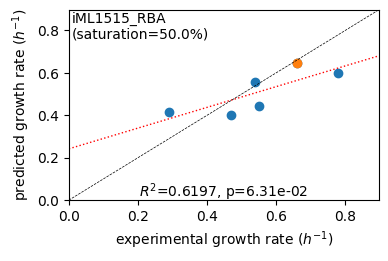

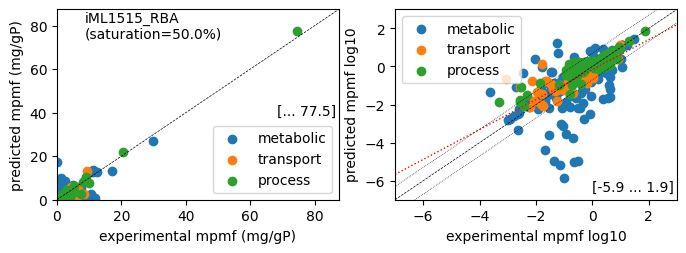

1 file(s) exported for "Load reaction data" into Escher maps
Duration: 140.5 s


In [19]:
# Optimize model using cobrapy and analyze results
start = time.time()
pred_results = {}
for cond, medium in conditions.items():
    rel_mmol_per_l =  (sigma / (1.0-min(sigma, .99))) * importer_km
    ex_sidx2mmol_per_l = {re.sub('EX_', '', ex_ridx): rel_mmol_per_l for ex_ridx in medium}
    ex_sidx2mmol_per_l['h_e'] = 100.0 * sigma   # H-symport reactions not to be constraint by proton concentration
    ro.medium = ex_sidx2mmol_per_l

    solution = ro.solve(gr_min=0.01, gr_max=1.2, bisection_tol=1e-3)
    if solution.status == 'optimal':
        gr = solution.objective_value
        pred_results[cond] = solution
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
              f'diff: {gr - exp_grs[cond]:6.3f}')
    else:
        print(f'{cond:25s}: INFEASIBLE')
            
rr = RbaResults(ro, pred_results, df_mpmf)
df_fluxes = rr.collect_fluxes()
df_all_net_fluxes = rr.collect_fluxes(net=True)    
metabolic_rids = [rid for rid in list(df_all_net_fluxes.index) if re.match('(PROD)|(DEGR)', rid) is None]
synthesis_rids = [rid for rid in list(df_all_net_fluxes.index) if re.match('(PROD)|(DEGR)', rid)]
df_net_fluxes = df_all_net_fluxes.loc[metabolic_rids]

# additional results with RBA
df_synt_fluxes = df_all_net_fluxes.loc[synthesis_rids]
df_proteins = rr.collect_protein_results('mg_per_gP')
df_enzyme_conc = rr.collect_enzyme_results('µmol_per_gDW')
df_rna_conc = rr.collect_rna_results('µmol_per_gDW')
df_occupancy = rr.collect_density_results()
df_capacity = rr.collect_density_results(capacity=True)

print('\nCorrelation with Schmidt, 2016, protein mass fractions:')    
rr.report_proteomics_correlation(scale='lin')
rr.report_proteomics_correlation(scale='log')
rr.report_protein_levels(reference_cond)
rr.plot_grs(exp_grs, highlight=reference_cond)
rr.plot_proteins(reference_cond, 
                 plot_fname=os.path.join('plots', f'{target_model}_proteins_{reference_cond}.pdf'))
rr.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', target_model))

print(f'Duration: {time.time()-start:.1f} s')

### synthesis and degradation fluxes

The following is a list of macromolecules for which synthesis and degradation fluxes have been determined: individual proteins, dummy proteins, RNA, and DNA.

In [20]:
print(f'{len(df_synt_fluxes)} synthesis and degradation fluxes')
df_synt_fluxes.head(5)

1644 synthesis and degradation fluxes


,reaction_str,gpr,groups,rank,mean mmol_per_gDWh,abs_mean mmol_per_gDWh,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
rid,,,,,,,,,,,,,
PROD_mrna,0.2406 atp_c + 0.2455 ctp_c + 0.2734 gtp_c + 0...,,,117,0.257421,0.257421,0.002986,0.260160,0.260558,0.256082,0.259335,0.253497,0.254895
DEGR_mrna,h2o_c + MM_mrna => 0.2406 amp_c + h_c + 0.2455...,,,119,0.254035,0.254035,0.003892,0.257596,0.258099,0.252331,0.256547,0.248879,0.250758
PROD_dna,0.254 dgtp_c + 0.254 dctp_c + 0.246 datp_c + 0...,,,273,0.050223,0.050223,0.006981,0.043741,0.042661,0.053745,0.045925,0.059000,0.056268
PROD_dummy_protein_c,0.001 fmettrna_c + 0.7457 gtp_c + 1.12 h2o_c +...,,,405,0.001201,0.001201,0.000201,0.001016,0.000988,0.001295,0.001074,0.001461,0.001373
PROD_dummy_protein_im,0.001 fmettrna_c + 0.7457 gtp_c + 2.6093 h2o_c...,,,448,0.000315,0.000315,0.000052,0.000268,0.000260,0.000340,0.000283,0.000382,0.000359


### enzyme concentrations

The RBA is used to determine the amount of enzyme required to catalyze the flux through a given reaction or process machine. Reactions are divided according to iso-enzyme, and the amount of enzyme is determined per sub-reaction.

In [21]:
print(f'{len(df_enzyme_conc)} enzymes and process machines')
df_enzyme_conc.head(3)

3799 enzymes and process machines


,mw_kDa,reaction_str,gpr,mean µmol_per_gDW,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
enzyme,,,,,,,,,,,
ACKr_iso2,43.290,ac_c + atp_c -> actp_c + adp_c,b2296,0.099341,0.145642,0.377952,0.004283,0.066173,0.133903,0.007331,0.006404
METS_iso1,84.674,5mthf_c + hcys__L_c => h_c + met__L_c + thf_c,b3829,0.095463,0.024430,0.084436,0.060015,0.109851,0.081371,0.126739,0.110365
NH4tpp,133.545,nh4_p -> nh4_c,b0451,0.072773,0.019047,0.062558,0.046934,0.083343,0.060847,0.098119,0.084838


In [22]:
# ribosome concentration in mg/gDW
rr.collect_enzyme_results('mg_per_gDW').loc[['pm_translation']]

,mw_kDa,reaction_str,gpr,mean mg_per_gDW,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
enzyme,,,,,,,,,,,
pm_translation,3160.0461,None,None,130.654575,23.78303,128.030783,92.072371,145.44653,117.616591,159.481958,141.279216


### RNA concentrations 

The concentrations of ribosomal RNA (rRNA), transfer RNA (tRNA), and messenger RNA (mRNA) are expressed in µmol/gDW or mg/gDW.

In [23]:
print(f'{len(df_rna_conc)} rnas')
df_rna_conc.head()

24 rnas


,mw_kDa,mean µmol_per_gDW,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
rna,,,,,,,,,
mrna,0.3210,6.571207,4.287356e-01,6.17891,6.123555,6.758931,6.294433,7.139194,6.932216
trnagly,24.4358,0.080400,1.520235e-17,0.08040,0.080400,0.080400,0.080400,0.080400,0.080400
trnaala,24.4338,0.067410,1.520235e-17,0.06741,0.067410,0.067410,0.067410,0.067410,0.067410
trnaleu,27.3881,0.059120,0.000000e+00,0.05912,0.059120,0.059120,0.059120,0.059120,0.059120
trnaval,24.4408,0.055530,0.000000e+00,0.05553,0.055530,0.055530,0.055530,0.055530,0.055530


### compartment occupancy

The RBA imposes constraints on the amount of protein and RNA that can be placed in each compartment. The occupancy level of the different compartments indicates which compartments are limiting. Total and used capacity per compartment in mmolAA/gDW can be reported as well.

In [24]:
# compartment occupancy
df_occupancy

,mean utilization,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
cid,,,,,,,,
im,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
c,0.718976,0.090138,0.777242,0.553841,0.779773,0.686179,0.790641,0.726181
om,0.168949,0.041153,0.207613,0.097730,0.156200,0.199676,0.194785,0.157693
p,0.109305,0.011715,0.098584,0.097072,0.114432,0.101746,0.124826,0.119168


In [25]:
# maximal compartment capacity
df_capacity

,mean capacity mmolAA_per_gDW,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
cid,,,,,,,,
c,4.891100,9.729507e-16,4.891100,4.891100,4.891100,4.891100,4.891100,4.891100
om,0.467240,1.284558e-02,0.479006,0.480685,0.461561,0.475509,0.450276,0.456403
p,0.458306,2.923985e-02,0.485120,0.489003,0.445224,0.477061,0.419843,0.433582
im,0.438812,8.274943e-03,0.446383,0.447452,0.435188,0.444154,0.427849,0.431844


## (Optional) Track progress

In [26]:
import scipy
import numpy as np

number = 6
xy = np.array([[df_mpmf.at[gene, reference_cond], df_proteins.at[gene, reference_cond]] 
                for gene in df_proteins.index if gene in df_mpmf.index])
log10_x, log10_y = rr.get_log10_xy(xy)
lin_pearson_r, _ = scipy.stats.pearsonr(xy[:, 0], xy[:, 1])
log_pearson_r, _ = scipy.stats.pearsonr(log10_x, log10_y)

predictions = load_parameter_file('protein_predictions.xlsx')
data = [[number, target_model, lin_pearson_r**2,log_pearson_r**2, len(xy), len(log10_x)]]
cols = ['No', 'model', 'lin r2', 'log r2', 'lin proteins', 'log proteins']
df = pd.DataFrame(data, columns=cols).set_index('No')
if number in predictions[reference_cond].index:
    predictions[reference_cond].drop(index=number, inplace=True)
predictions[reference_cond] = pd.concat((predictions[reference_cond], df)).sort_index()
write_parameter_file('protein_predictions.xlsx', predictions)
predictions[reference_cond]

1 table(s) with parameters loaded from protein_predictions.xlsx (Thu Feb 12 15:25:51 2026)
1 table(s) with parameters written to protein_predictions.xlsx


,model,lin r2,log r2,lin proteins,log proteins
No,,,,,
1,iML1515_default_GECKO,0.033244,0.190225,1018,299
2,iML1515_modified_GECKO,0.135981,0.201613,999,322
3,iML1515_predicted_GECKO,0.078803,0.268769,999,308
4,iML1515_manual_adjust_GECKO,0.205413,0.333470,999,308
5,iML1515_predicted_fit_GECKO,0.869850,0.549757,999,313
6,iML1515_RBA,0.855003,0.479941,1112,428


## Closing remarks

The development of a RBA model necessitates a significantly greater investment of effort compared to a GECKO model, yet it offers the advantage of generating more realistic models. The utilization of organism-specific knowledge is imperative, as it provides a foundation for defining the processes to be implemented, the compartments to be incorporated, and the compartmental constraints to be imposed. Additionally, it determines the targets concentrations and fluxes to be established, the target values to be configured, and the realistic growth-dependent functions to be designated for dynamic value assignments. The parametrizations selected for this RBA model could serve as a foundational starting point for future model enhancements and as a paradigm for RBA models of other organisms that one may wish to develop. Despite the augmented intricacy, the RBA optimization outcomes persist in demonstrating substantial correlation with empirical data, encompassing both the predicted growth rates and the predicted protein concentrations. 

In a manner analogous to the GECKO model of a particular organism serving as a precursor to the RBA model, the RBA model has the potential to serve as a precursor to a GBA model (Dourado & Lercher, 2020).The extension to GBA would entail defining default or specific reaction kinetics for each of the enzyme-catalyzed reactions and introducing metabolite concentration variables. 

An advantage of the f2xba modeling framework is that the resulting models contain all information and annotation data from the foundational GEM, which can be exploited in downstream processing. The models are self-contained and fully compliant with the SBML standard (Hucka et al., 2019), which facilitates sharing and processing by SBML-compliant tools. However, RBA model optimization requires support from the f2xba Python package. Loading and optimization of this SBML-coded RBA model in environments other than Python would require efforts to port relevant coding sections from f2xba to the other environment.

In the subsequent tutorials, we will augment our models with thermodynamic constraints, commencing with a thermodynamic FBA model.


---
---
## (Alternative) gurobipy - model optimization

The gurobipy interface has been demonstrated to exhibit superior performance in terms of speed for RBA model optimizations. This enhancement can be attributed to the elimination of overhead introduced by cobrapy.

In [27]:
# Load model using gurobiy
start = time.time()
fname = os.path.join('SBML_models', f'{target_model}.xml')
ro = RbaOptimization(fname)
sigma = ro.avg_enz_saturation
importer_km = ro.importer_km
print(f'average saturation level: {sigma}, importer Km: {importer_km} mmol/l')
all_genes = set(ro.m_dict['fbcGeneProducts']['label'].values)
tx_genes, metab_genes = ro.get_tx_metab_genes()
pm_genes = all_genes.difference(tx_genes.union(metab_genes))
print(f'{len(all_genes)} genes: ({len(tx_genes)}) transporter, ({len(metab_genes)}) metabolic, '
      f'({len(pm_genes)}) process machines')
print(f'Duration: {time.time()-start:.1f} s')

SBML model loaded by sbmlxdf: SBML_models/iML1515_RBA.xml (Thu Feb 12 15:27:47 2026)
LP Model of iML1515_RBA
9758 variables, 8953 constraints, 119517 non-zero matrix coefficients
3792 enzymes, 7 process machines
RBA enzyme efficiency constraints configured (C_EF_xxx, C_ER_xxx) ≤ 0
average saturation level: 0.5, importer Km: 1.0 mmol/l
1611 genes: (492) transporter, (1025) metabolic, (94) process machines
Duration: 23.9 s


Acetate                  : pred gr: 0.415 h-1 vs. exp 0.290, diff:  0.125
Glycerol                 : pred gr: 0.405 h-1 vs. exp 0.470, diff: -0.065
Fructose                 : pred gr: 0.553 h-1 vs. exp 0.540, diff:  0.013
L-Malate                 : pred gr: 0.443 h-1 vs. exp 0.550, diff: -0.107
Glucose                  : pred gr: 0.646 h-1 vs. exp 0.660, diff: -0.014
Glucose 6-Phosphate      : pred gr: 0.599 h-1 vs. exp 0.780, diff: -0.181

Correlation with Schmidt, 2016, protein mass fractions:
Acetate                  : r² = 0.3654, p = 9.57e-112 (1112 proteins lin scale)
Glycerol                 : r² = 0.5342, p = 2.27e-186 (1112 proteins lin scale)
Fructose                 : r² = 0.6779, p = 2.59e-275 (1112 proteins lin scale)
Glucose                  : r² = 0.8519, p = 0.00e+00 (1112 proteins lin scale)
Acetate                  : r² = 0.4168, p = 3.06e-51 ( 423 proteins log scale)
Glycerol                 : r² = 0.4183, p = 3.47e-52 ( 429 proteins log scale)
Fructose              

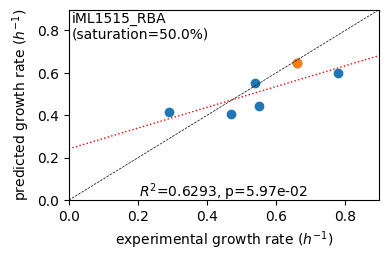

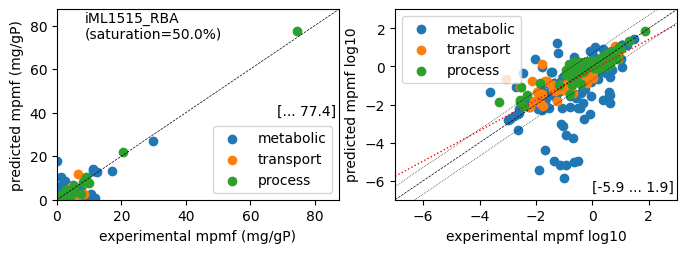

1 file(s) exported for "Load reaction data" into Escher maps
Duration: 23.9 s


In [28]:
# Optimize model using gurobiy and analyze results
start = time.time()
pred_results = {}
for cond, medium in conditions.items():
    rel_mmol_per_l =  (sigma / (1.0-min(sigma, .99))) * importer_km
    ex_sidx2mmol_per_l = {re.sub('EX_', '', ex_ridx): rel_mmol_per_l for ex_ridx in medium}
    ex_sidx2mmol_per_l['h_e'] = 100.0 * sigma   # H-symport reactions to be not constraint by main metabolite
    ro.medium = ex_sidx2mmol_per_l

    solution = ro.solve(gr_min=0.01, gr_max=1.2, bisection_tol=1e-3)
    if solution.status == 'optimal':
        gr = solution.objective_value
        pred_results[cond] = solution
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
              f'diff: {gr - exp_grs[cond]:6.3f}')
    else:
        print(f'{cond:25s}: INFEASIBLE')
            
rr = RbaResults(ro, pred_results, df_mpmf)
df_fluxes = rr.collect_fluxes()
df_all_net_fluxes = rr.collect_fluxes(net=True)    
metabolic_rids = [rid for rid in list(df_all_net_fluxes.index) if re.match('(PROD)|(DEGR)', rid) is None]
synthesis_rids = [rid for rid in list(df_all_net_fluxes.index) if re.match('(PROD)|(DEGR)', rid)]
df_net_fluxes = df_all_net_fluxes.loc[metabolic_rids]

# additional results with RBA
df_synt_fluxes = df_all_net_fluxes.loc[synthesis_rids]
df_proteins = rr.collect_protein_results('mg_per_gP')
df_enzyme_conc = rr.collect_enzyme_results('µmol_per_gDW')
df_rna_conc = rr.collect_rna_results('µmol_per_gDW')
df_occupancy = rr.collect_density_results()
df_capacity = rr.collect_density_results(capacity=True)

print('\nCorrelation with Schmidt, 2016, protein mass fractions:')    
rr.report_proteomics_correlation(scale='lin')
rr.report_proteomics_correlation(scale='log')
# rr.report_protein_levels(reference_cond)
rr.plot_grs(exp_grs, highlight=reference_cond)
rr.plot_proteins(reference_cond, 
                 plot_fname=os.path.join('plots', f'{target_model}_proteins_{reference_cond}.pdf'))
rr.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', target_model))
print(f'Duration: {time.time()-start:.1f} s')

---
---
## References

- Bulović, A., Fischer, S., Dinh, M., Golib, F., Liebermeister, W., Poirier, C., Tournier, L., Klipp, E., Fromion, V., & Goelzer, A. (2019). Automated generation of bacterial resource allocation models. Metabolic Engineering, 55, 12-22. https://doi.org/https://doi.org/10.1016/j.ymben.2019.06.001 
- Dourado, H., & Lercher, M. J. (2020). An analytical theory of balanced cellular growth. Nat Commun, 11(1), 1226. https://doi.org/10.1038/s41467-020-14751-w 
- Goelzer, A., Fromion, V., & Scorletti, G. (2011). Cell design in bacteria as a convex optimization problem. Automatica, 47(6), 1210-1218. https://doi.org/https://doi.org/10.1016/j.automatica.2011.02.038 
- Hucka, M., Bergmann, F. T., Chaouiya, C., Dräger, A., Hoops, S., Keating, S. M., König, M., Novère, N. L., Myers, C. J., Olivier, B. G., Sahle, S., Schaff, J. C., Sheriff, R., Smith, L. P., Waltemath, D., Wilkinson, D. J., & Zhang, F. (2019). The Systems Biology Markup Language (SBML): Language Specification for Level 3 Version 2 Core Release 2. J Integr Bioinform, 16(2). https://doi.org/10.1515/jib-2019-0021 
- Orth, J. D., Conrad, T. M., Na, J., Lerman, J. A., Nam, H., Feist, A. M., & Palsson, B. Ø. (2011). A comprehensive genome-scale reconstruction of Escherichia coli metabolism. Molecular Systems Biology, 7(1), 535. https://doi.org/https://doi.org/10.1038/msb.2011.65 

